In [1]:
import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

In [2]:
from multiprocessing import cpu_count
n_cores = cpu_count()
print(f'Number of Logical CPU cores: {n_cores}')

Number of Logical CPU cores: 20


In [3]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [4]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
        self.memory += other.memory
        return self

    def __add__(self, other):
        self.memory = self.memory + other.memory
        return self

In [5]:
frames = []

def fitness_function_pt(
    multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False
):
    memory = ReplayMemory(10000)
    rewards = []

    for _ in range(num_episodes):
        # get initial state of the environment
        observation = env.reset()
        observation = observation[0]

        for _ in range(episode_duration):
            if render:
                frames.append(env.render())

            input_sample = torch.from_numpy(observation.reshape((1, -1))).float()

            # what goes here? TODO
            action = torch.argmax(multitree.get_output_pt(input_sample))
            observation, reward, terminated, truncated, info = env.step(action.item())
            rewards.append(reward)
            output_sample = torch.from_numpy(observation.reshape((1, -1))).float()
            memory.push(
                input_sample,
                torch.tensor([[action.item()]]),
                output_sample,
                torch.tensor([reward]),
            )
            if (terminated or truncated) and not ignore_done:
                break

    fitness = np.sum(rewards)

    return fitness, memory

## Self adaptation in coefficient mutation

adding an additional parameter $\sigma$ is added to the constant node.  

$\sigma = \max\left(\exp(N(0,\gamma^2)), \epsilon\right)$

$c' = N(c, \sigma^2)$

$\sigma ' = \max(\sigma \exp(N(0,\gamma^2)), \epsilon)$

In [6]:
from genepro.multitree import Multitree
import numpy as np


class AdaptiveConstant(Constant):
    def __init__(self, value: float = None):
        super().__init__(value)
        # self.gamma = gamma
        # self.epsilon = epsilon
        self.sigma = (
            1.0  # np.max([np.exp(self.gamma * np.random.randn()), self.epsilon])
        )

    def set_sigma(self, sigma):
        self.sigma = sigma


def coeff_adaptive_mutation(
    multitree: Multitree,
    prob_coeff_mut: float = 0.25,
    gamma: float = 0.1,
    epsilon: float = 1e-16,
) -> Node:
    """
    Applies random coefficient mutations to constant nodes

    Parameters
    ----------
    tree : Node
      the tree to which coefficient mutations are applied
    prob_coeff_mut : float, optional
      the probability with which coefficients are mutated (default is 0.25)
    temp : float, optional
      "temperature" that indicates the strength of coefficient mutation, it is relative to the current value (i.e., v' = v + temp*abs(v)*N(0,1))

    Returns
    -------
    Node
      the tree after coefficient mutation (it is the same as the tree in input)
    """
    r = np.random.randint(multitree.n_trees)
    tree = multitree.children[r]
    coeffs = [n for n in tree.get_subtree() if type(n) == Constant]
    for c in coeffs:
        # decide wheter it should be applied
        if np.random.uniform() < prob_coeff_mut:
            v = c.get_value()
            # update the value by +- sigma*N(0,1)
            new_sigma = np.max([c.sigma * np.exp(gamma * np.random.randn()), epsilon])
            c.set_sigma(new_sigma)

            new_v = v + c.sigma * np.random.randn()

            c.set_value(new_v)

    multitree.children[r] = tree
    return multitree

In [7]:
# import numpy as np
from copy import deepcopy
from joblib.parallel import Parallel, delayed
import itertools



def paralel_tournament_selection(contestants : list, num_to_select : int, tournament_size : int=4) -> list:
  """
  Performs tournament selection on the contestants until the given number of selected contestants is reached;
  note that `len(contestants)` needs to be a multiple of `tournament_size` and similarly for `num_to_select`

  Parameters
  ----------
  contestants : list
    list of Node containing trees that undergo the selection
  num_survivors : int
    how many should be selected
  tournament_size : int, optional
    the size (window) of tournament selection (default is 4)

  Returns
  -------
  list
    list containing (copies of) the trees that were selected
  """
  selected = list()

  n = len(contestants)
  num_selected_per_parse = n // tournament_size
  num_parses = num_to_select // num_selected_per_parse

  # assert quantities are compatible
  assert n / tournament_size == num_selected_per_parse, "Number of contestants {} is not a multiple of tournament size {}".format(n,tournament_size)
  assert num_to_select / num_selected_per_parse == num_parses
 
  def tournament():
    # shuffle
    temp = np.random.permutation(contestants)
    fitnesses = np.array([t.fitness for t in temp])

    winning_indices = np.argmax(fitnesses.reshape((-1, tournament_size)), axis=1)
    winning_indices += np.arange(0, n, tournament_size)

    return [deepcopy(temp[i]) for i in winning_indices]
  
  selected = Parallel(n_jobs=20)(delayed(tournament)() for _ in range(num_parses))
#   for _ in range(num_parses):
#     # shuffle
#     np.random.shuffle(contestants)
#     fitnesses = np.array([t.fitness for t in contestants])

#     winning_indices = np.argmax(fitnesses.reshape((-1, tournament_size)), axis=1)
#     winning_indices += np.arange(0, n, tournament_size)

#     selected += [deepcopy(contestants[i]) for i in winning_indices]
  selected = list(itertools.chain.from_iterable(selected))
  # print(selected)
  return selected
 

In [ ]:
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [
    AdaptiveConstant()
]  # Think about the probability of sampling a coefficient
internal_nodes = [
    Plus(),
    Minus(),
    Times(),
    Div(),
    Square(),
    Sqrt(),
]  # Add your own operators here


evo_adaptive = Evolution(
    fitness_function_pt,
    internal_nodes,
    leaf_nodes,
    4,
    pop_size=64,
    max_gens=5,
    max_tree_size=40,
    coeff_opts=[
        {
            "fun": coeff_adaptive_mutation,
            "rate": 0.3, # rate of applying the mutation to the variation
            "prob": 1, # probability of applying the mutation to the coefficient
            "gamma": 0.15, # gamma parameter for the mutation (strength of the mutation)
            "epsilon": 1e-16, # epsilon parameter for the mutation (minimum value of sigma)
        }
    ],
    # selection={"fun":paralel_tournament_selection},
    n_jobs=n_cores,
    verbose=True,
)

evo_adaptive.evolve()

gen: 1,	best of gen fitness: -327.148,	best of gen size: 14
gen: 2,	best of gen fitness: -445.237,	best of gen size: 20
gen: 3,	best of gen fitness: -199.913,	best of gen size: 29
gen: 4,	best of gen fitness: -382.130,	best of gen size: 14
gen: 5,	best of gen fitness: -324.756,	best of gen size: 23


['((((x_5-x_2)*(x_6*x_5)))**2/((x_6)**2/x_0))', '(((x_7-x_5)+((2.953815460205078*x_3))**2)*(((x_6-x_2))**2)**2)', '(((x_5-x_6)-(((sqrt(abs(x_5))+x_7)*((4.479225158691406+x_3)*-1.5066131353378296))+x_1))-((x_7-sqrt(abs(x_6)))-x_5))', '(sqrt(abs(((x_6--3.644897937774658)*-3.1661722660064697)))*((x_5/(x_7/x_0))+x_7))']
-1107.1995092204595


MovieWriter imagemagick unavailable; using Pillow instead.


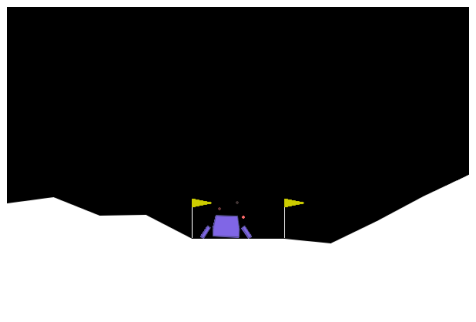

In [9]:
def get_test_score(tree):
    rewards = []

    for i in range(10):
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]

      for _ in range(500):    
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = torch.argmax(output)
        observation, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)


        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break

    fitness = np.sum(rewards)
    
    return fitness

best = evo_adaptive.best_of_gens[-1]

print(best.get_readable_repr())
print(get_test_score(best))

# frames = []

# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)

frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames)

### Setup experiment for self adaptive mutation

run 7 test and one with the normal setup 

In [12]:
experiments = []

num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes_adaptive = leaf_nodes + [
    AdaptiveConstant()
] 
leaf_nodes_fixed = leaf_nodes + [
    Constant()
]
internal_nodes = [
    Plus(),
    Minus(),
    Times(),
    Div(),
    Min(),
    Max(),
    Sin(),
    # Square(),
    # Sqrt(),
]  # Add your own operators here

n_trees = 4
pop_size = 64
max_tree_size = 40
max_gens = 1




n_paralell_experiments = 4
n_jobs_per_experiment = n_cores // n_paralell_experiments

experiments = []

# default experiement
experiments.append(dict(
    fitness_function = fitness_function_pt,
    internal_nodes=internal_nodes,
    leaf_nodes=leaf_nodes_fixed,
    n_trees=n_trees,
    pop_size=pop_size,
    max_gens=max_gens,
    max_tree_size=max_tree_size,
    coeff_opts=[
        {
            "fun": coeff_mutation,
            "rate": 0.5, # rate of applying the mutation to the variation
            "prob": 1, # probability of applying the mutation to the coefficient
            "gamma": 0.15, # gamma parameter for the mutation (strength of the mutation)
            "epsilon": 1e-16, # epsilon parameter for the mutation (minimum value of sigma)
        }
    ],
    # selection={"fun":tournament_selection},
    n_jobs=n_cores,
    verbose=True,
    ))

evo_test= Evolution(**exp_dict)

evo_test.evolve()

gen: 1,	best of gen fitness: -112.685,	best of gen size: 20
gen: 2,	best of gen fitness: -48.990,	best of gen size: 20
gen: 3,	best of gen fitness: 199.260,	best of gen size: 32
gen: 4,	best of gen fitness: 77.889,	best of gen size: 35
gen: 5,	best of gen fitness: 447.074,	best of gen size: 30


In [ ]:
def run_experiment(evo):
    evo_adaptive.evolve()
    best = evo_adaptive.best_of_gens[-1]
    return best